In [1]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [55]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-29 RZ hTERT SPH DMSO conc test"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                        FileName_RGB  ImageNumber
0  2024-07-29 RZ hTERT SPH DMSO conc test 0H (Mul...            1
1  2024-07-29 RZ hTERT SPH DMSO conc test 24H (Mu...            2


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-29 RZ hTERT SPH DMSO conc test\2024-07-29 RZ hTERT SPH DMSO conc test 0H (Multichannel).toml


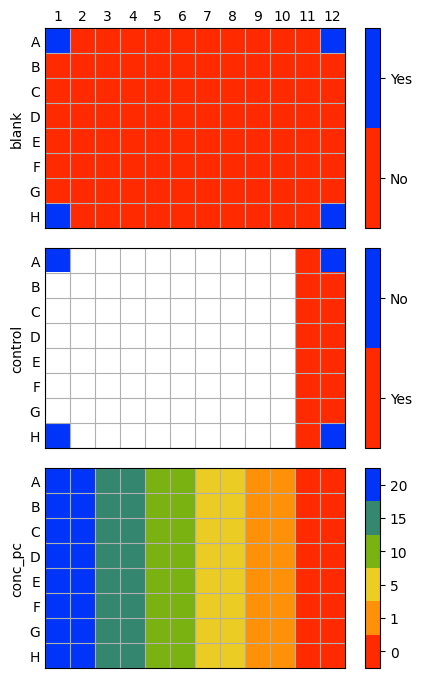

In [56]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [57]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
187   D   12
188   E   12
189   F   12
190   G   12
191   H   12

[192 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [58]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_pc"]] = data_plate[["conc_pc"]].apply(pd.to_numeric)

print(data_plate)

    row col  ImageNumber  ObjectNumber  \
0     A   1            1             1   
1     B   1            1             2   
2     C   1            1             3   
3     D   1            1             4   
4     E   1            1             5   
..   ..  ..          ...           ...   
187   D  12            2            92   
188   E  12            2            93   
189   F  12            2            94   
190   G  12            2            95   
191   H  12            2            96   

     Intensity_IntegratedIntensity_OrigGreen  \
0                                  86.337259   
1                                  68.662748   
2                                  78.392160   
3                                  69.701964   
4                                  70.423532   
..                                       ...   
187                               846.713750   
188                              1544.627495   
189                              1540.039261   
190            

0H plate as a reference plate

<Axes: xlabel='col', ylabel='row'>

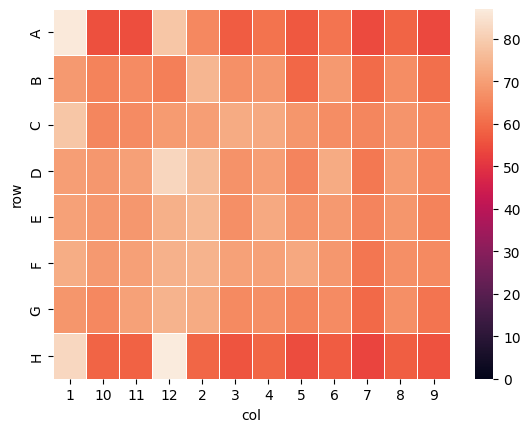

In [59]:
reference_plate = data_plate[(data_plate['RZ_incubation'] == '0H')].copy()

# print(reference_plate)

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

# print(reference_plate['Intensity_IntegratedIntensity_OrigGreen'])

0.012323045687402423
0     1.295279
1     1.030116
2     1.176082
3     1.045707
4     1.056532
        ...   
91    1.228444
92    1.103834
93    1.110130
94    1.112718
95    1.304398
Name: Mean_dif, Length: 96, dtype: float64


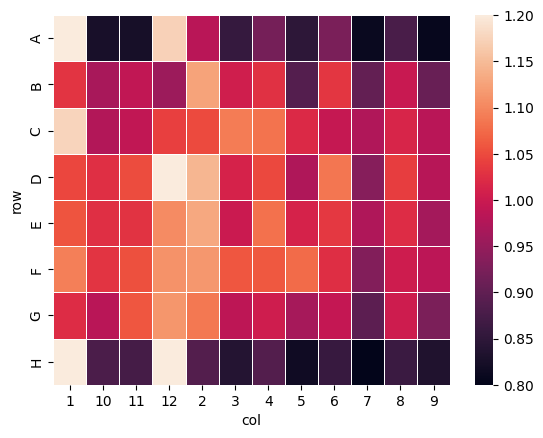

In [60]:
p = "2024-07-29 RZ hTERT SPH DMSO conc test 0H (Multichannel).tif"

mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

print(mean)

reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

reference_plate['Mean_corr'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

print(reference_plate['Mean_dif'])

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Mean_dif")

sns.heatmap(heatmap_df, linewidth=.5, vmax=1.2, vmin=0.80 )


plt.show()


   row col  ImageNumber  ObjectNumber  \
0    A   1            2             1   
1    B   1            2             2   
2    C   1            2             3   
3    D   1            2             4   
4    E   1            2             5   
..  ..  ..          ...           ...   
91   D  12            2            92   
92   E  12            2            93   
93   F  12            2            94   
94   G  12            2            95   
95   H  12            2            96   

    Intensity_IntegratedIntensity_OrigGreen  \
0                                109.078435   
1                                131.788238   
2                                157.078437   
3                                143.568631   
4                                147.552945   
..                                      ...   
91                               846.713750   
92                              1544.627495   
93                              1540.039261   
94                              1412.

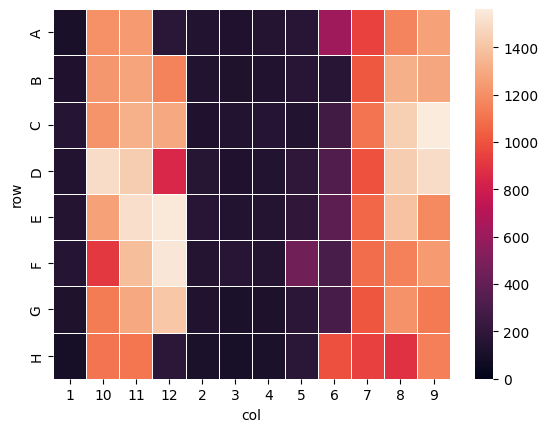

In [61]:
sample_plate = data_plate[(data_plate['RZ_incubation'] == '24H')].copy().reset_index(drop=True)

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(sample_plate)

0     0.025853
1     0.024841
2     0.033804
3     0.027471
4     0.028526
        ...   
91    0.190328
92    0.311988
93    0.312835
94    0.287583
95    0.044840
Name: Mean_corr, Length: 96, dtype: float64


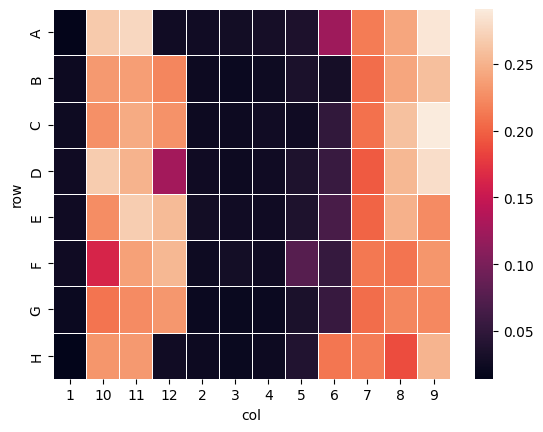

In [62]:
sample_plate['Mean_dif'] = reference_plate['Mean_dif']

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']*sample_plate['Mean_dif']

print(sample_plate['Mean_corr'])

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

# sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

p = "2024-07-29 RZ hTERT SPH DMSO conc test 24H (Multichannel).tif"

mean_sample = sample_plate[(sample_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

sample_plate['Mean_corr_dif'] = sample_plate['Mean_corr']/mean_sample


heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

sns.heatmap(heatmap_df, linewidth=.5 )


plt.show()


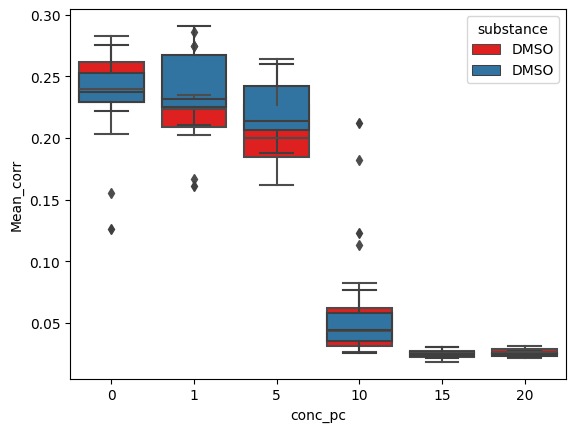

In [63]:
# row_drop_list = ['A','H']

# cleared_data = sample_plate[~sample_plate['row'].isin(row_drop_list)]

cleared_data = sample_plate[sample_plate['blank']=='No']

well_drop_list = ['']

ax = sns.boxplot(data=cleared_data, x="conc_pc", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'])

ay = sns.boxplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance')

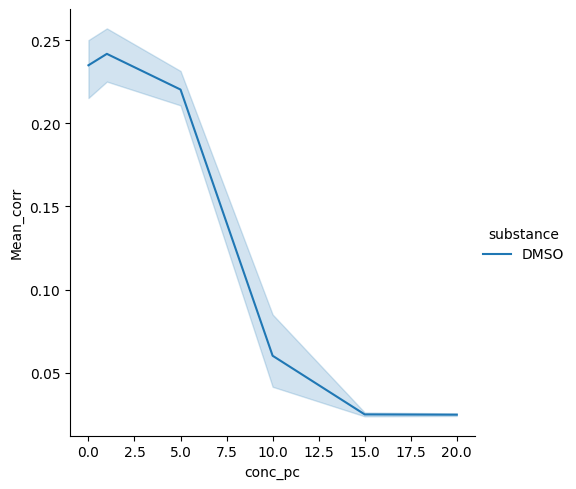

In [70]:

# ax = sns.relplot(data=cleared_data, x="conc_pc", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'],  kind="line")

ay = sns.relplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance',  kind="line")
# ay = sns.stripplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance')

# ax.set(xscale="symlog")
# ay.set(xscale="symlog")

# ax.set(xlim=(0, 200))
# ay.set(xlim=(0, 200))

C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\

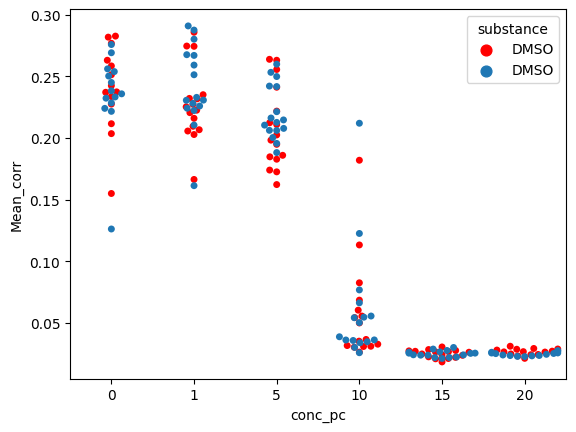

In [72]:
ax = sns.swarmplot(data=cleared_data, x="conc_pc", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'])

ay = sns.swarmplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance')


Blank and control calculation for each plate

In [73]:
blank_array = []

p = "2024-07-29 RZ hTERT SPH DMSO conc test 24H (Multichannel).tif"



blank_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
blank_std_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

bc_array_i = [blank_p, blank_std_p ,p]

blank_array.append(bc_array_i)

blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank = pd.merge(sample_plate, blank_df, on=['FileName_RGB'])

print(blank_df)


   blank_mean  blank_std                                       FileName_RGB
0    0.020766   0.006875  2024-07-29 RZ hTERT SPH DMSO conc test 24H (Mu...


In [74]:
data_plate_with_blank['Green_blanked'] = data_plate_with_blank['Mean_corr'] - data_plate_with_blank['blank_mean']


data_plate_wo_blank = data_plate_with_blank[data_plate_with_blank.blank == 'No'].copy() #dataframe without blank

control_array = []

control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                & (data_plate_wo_blank['blank'] == 'No') & 
                                (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                    & (data_plate_wo_blank['blank'] == 'No') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()

bc_array_i = [control_p,control_std_p,p]

control_array.append(bc_array_i)

control_df = pd.DataFrame(control_array, columns = ['control_mean', 'control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])

data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100


print(data_plate_with_control[(data_plate_with_control['control'] == 'Yes') 
                                & (data_plate_with_control['blank'] == 'No') & 
                                (data_plate_with_control['FileName_RGB'] == p)].loc[:,'Green_relative'])

   control_mean  control_std  \
0      0.214222      0.03528   

                                        FileName_RGB  
0  2024-07-29 RZ hTERT SPH DMSO conc test 24H (Mu...  
78    119.052248
79    100.381260
80    104.672109
81    107.119149
82    115.941812
83    101.531718
84     94.870794
85     99.196787
86     93.744949
87     96.940687
88     49.180948
89    109.833452
90    108.802617
91     98.731472
Name: Green_relative, dtype: float64


Plotting


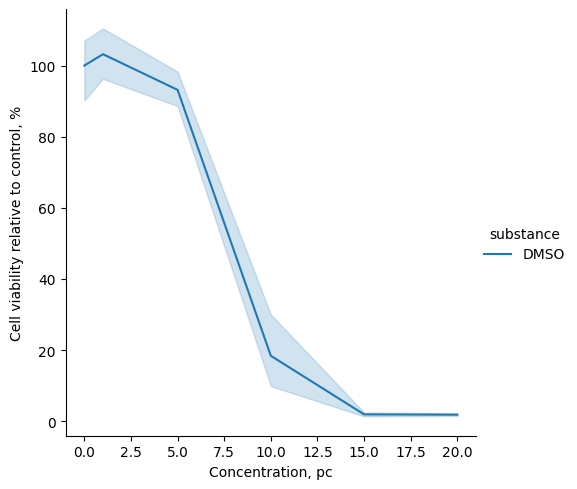

In [77]:

# row_drop_list = ['A','H']

row_drop_list = []

cleared_data = data_plate_with_control[~data_plate_with_control['row'].isin(row_drop_list)]

ax = sns.relplot(data=cleared_data, x="conc_pc", y="Green_relative", kind="line", hue = 'substance')

# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, pc', ylabel='Cell viability relative to control, %')
# ax.set(xscale="symlog")

# ax.set(xlim=(0, 200),ylim = (0,120))

# plt.show()



C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='conc_pc', ylabel='Green_relative'>

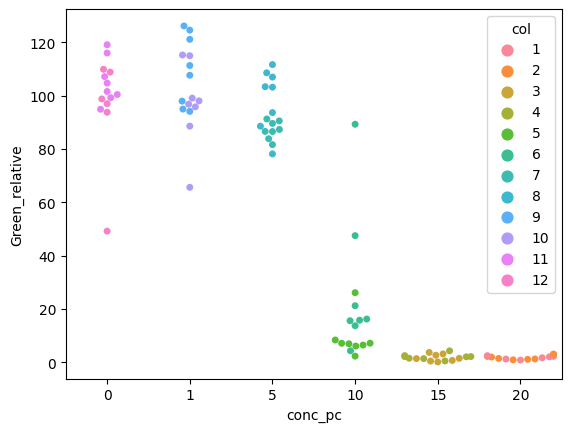

In [79]:
sns.swarmplot(data=data_plate_with_control, x="conc_pc", y="Green_relative", hue = 'col')